In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from nb_005b import *

# Carvana

## Setup

(See final section of notebook for one-time data processing steps.)

In [ ]:
PATH = Path('data/carvana')
PATH_PNG = PATH/'train_masks_png'
PATH_X_FULL = PATH/'train'
PATH_X_128 = PATH/'train-128'
PATH_Y_FULL = PATH_PNG
PATH_Y_128 = PATH/'train_masks-128'

# start with the 128x128 images
PATH_X = PATH_X_128
PATH_Y = PATH_Y_128

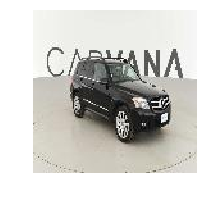

In [ ]:
img_f = next(PATH_X.iterdir())
open_image(img_f).show()

In [ ]:
#export
class ImageMask(Image):
    def lighting(self, func, *args, **kwargs): return self
    
    def refresh(self):
        self.sample_kwargs['mode'] = 'nearest'
        return super().refresh()

def open_mask(fn): return ImageMask(pil2tensor(PIL.Image.open(fn)).long())

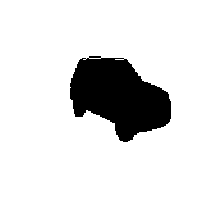

In [ ]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}_mask.png'

img_y_f = get_y_fn(img_f)
y = open_mask(img_y_f)
y.show()

In [ ]:
#export
# Same as `show_image`, but renamed with _ prefix
def _show_image(img, ax=None, figsize=(3,3), hide_axis=True, cmap='binary', alpha=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    return ax

def show_image(x, y=None, ax=None, figsize=(3,3), alpha=0.5, hide_axis=True, cmap='viridis'):
    ax1 = _show_image(x, ax=ax, hide_axis=hide_axis, cmap=cmap)
    if y is not None: _show_image(y, ax=ax1, alpha=alpha, hide_axis=hide_axis, cmap=cmap)
    if hide_axis: ax1.axis('off')
        
def _show(self, ax=None, y=None, **kwargs):
    if y is not None: y=y.data
    return show_image(self.data, ax=ax, y=y, **kwargs)

Image.show = _show

torch.Size([3, 128, 128])

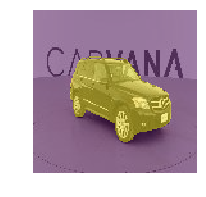

In [ ]:
x = open_image(img_f)
x.show(y=y)
x.shape

## Dataset

- data types: regr, class, seg, bbox, polygon, generative (s/res, color), custom

In [ ]:
#export
class DatasetTfm(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:bool=False, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.x_kwargs = ds,tfms,tfm_y,kwargs
        self.y_kwargs = {**self.x_kwargs, 'do_resolve':False} # don't reset random vars
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        
        x = apply_tfms(self.tfms, x, **self.x_kwargs)
        if self.tfm_y: y = apply_tfms(self.tfms, y, **self.y_kwargs)
        return x, y
    
    def __getattr__(self,k): return getattr(self.ds, k)
    
import nb_002b,nb_005
nb_002b.DatasetTfm = DatasetTfm  
nb_005.DatasetTfm  = DatasetTfm  

In [ ]:
#export
class MatchedImageDataset(DatasetBase):
    def __init__(self, x:Collection[Path], y:Collection[Path]):
        assert len(x)==len(y)
        self.x,self.y = np.array(x),np.array(y)

    def __getitem__(self, i): 
        return open_image(self.x[i]), open_mask(self.y[i])

In [ ]:
def get_datasets(path):
    x_fns = [o for o in path.iterdir() if o.is_file()]
    y_fns = [get_y_fn(o) for o in x_fns]
    mask = [o>=1008 for o in range(len(x_fns))]
    arrs = arrays_split(mask, x_fns, y_fns)
    return [MatchedImageDataset(*o) for o in arrs]

In [ ]:
train_ds,valid_ds = get_datasets(PATH_X_128)
train_ds,valid_ds

(MatchedImageDataset of len 4080, MatchedImageDataset of len 1008)

In [ ]:
x,y = next(iter(train_ds))
x.shape, y.shape, type(x), type(y)

(torch.Size([3, 128, 128]),
 torch.Size([1, 128, 128]),
 nb_002.Image,
 __main__.ImageMask)

In [ ]:
size=128

In [ ]:
def get_tfm_datasets(size):
    datasets = get_datasets(PATH_X_128 if size<=128 else PATH_X_FULL)
    tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2)
    return transform_datasets(train_ds, valid_ds, tfms=tfms, tfm_y=True, size=size)

In [ ]:
train_tds,*_ = get_tfm_datasets(size)

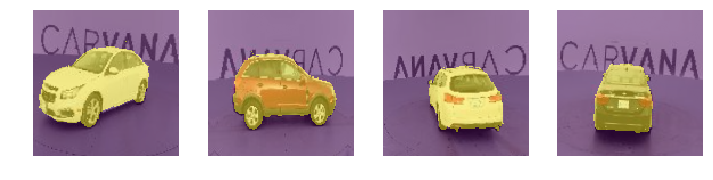

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    imgx,imgy = train_tds[i]
    imgx.show(ax, y=imgy)

In [ ]:
#export
def normalize_batch(b, mean, std, do_y=False):
    x,y = b
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean, std, do_y=False, device=None):
    if device is None: device=default_device
    return (partial(normalize_batch, mean=mean.to(device),std=std.to(device), do_y=do_y),
            partial(denormalize,     mean=mean,           std=std))

In [ ]:
default_norm,default_denorm = normalize_funcs(*imagenet_stats)
bs = 64

In [ ]:
def get_data(size, bs):
    return DataBunch.create(*get_tfm_datasets(size), bs=bs, tfms=default_norm)

In [ ]:
data = get_data(size, bs)

In [ ]:
#export
def show_xy_images(x,y,rows,figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()): show_image(x[i], y=y[i], ax=ax)
    plt.tight_layout()

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

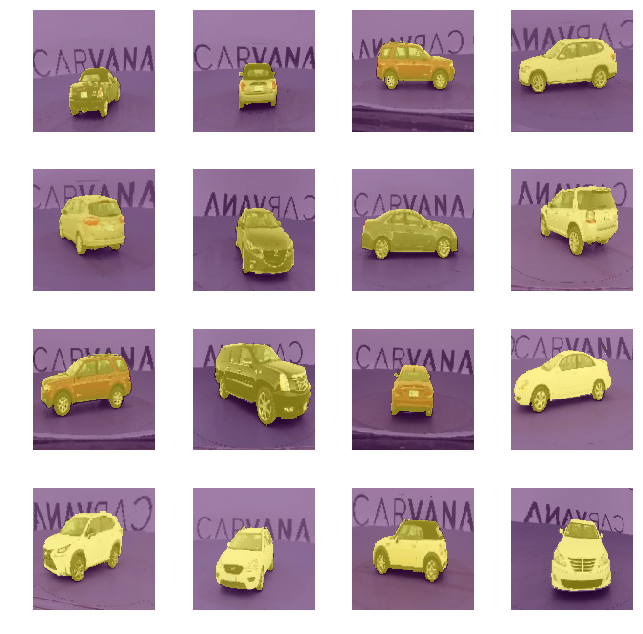

In [ ]:
x,y = next(iter(data.train_dl))
x,y = x.cpu(),y.cpu()
x = default_denorm(x)
show_xy_images(x,y,4, figsize=(9,9))
x.shape, y.shape

## Model

In [ ]:
#export
class Debugger(nn.Module): 
    def forward(self,x): 
        set_trace()
        return x

class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = conv2d_trans(nin, nout)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): 
        return self.bn(F.relu(self.conv(x)))

def std_upsample_head(c, *nfs):
    return nn.Sequential(
        nn.ReLU(),
        *(StdUpsample(nfs[i],nfs[i+1]) for i in range(4)),
        conv2d_trans(nfs[-1], c)
    )

In [ ]:
head = std_upsample_head(2, 512,256,256,256,256)
head

Sequential(
  (0): ReLU()
  (1): StdUpsample(
    (conv): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): StdUpsample(
    (conv): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): ConvTranspose2d(256, 2, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
#export
def dice(input, targs):
    "dice coefficient metric for binary target"
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return 2. * intersect / union

def accuracy(input, targs):
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

class CrossEntropyFlat(nn.CrossEntropyLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target"
    def forward(self, input, target):
        n,c,*_ = input.shape
        return super().forward(input.view(n, c, -1), target.view(n, -1))

In [ ]:
metrics=[accuracy, dice]

In [ ]:
learn = ConvLearner(data, tvm.resnet34, 2, custom_head=head,
                    metrics=metrics, loss_fn=CrossEntropyFlat())

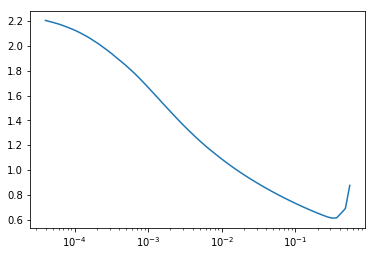

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-1

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 01:43
epoch  train loss  valid loss  accuracy  dice    
0      0.181944    0.125549    0.950104  0.886996  (00:10)
1      0.095540    0.098315    0.959278  0.908581  (00:10)
2      0.068498    0.079473    0.968269  0.926979  (00:10)
3      0.056722    0.056674    0.975508  0.939957  (00:10)
4      0.060056    0.124180    0.970560  0.928529  (00:10)
5      0.068534    0.038382    0.983916  0.960854  (00:10)
6      0.048061    0.035001    0.985501  0.964682  (00:10)
7      0.039850    0.032957    0.986267  0.966015  (00:10)
8      0.035625    0.028758    0.988224  0.971076  (00:10)
9      0.032893    0.027913    0.988449  0.971958  (00:10)



In [ ]:
learn.unfreeze()

In [ ]:
learn.save('0')

In [ ]:
learn.load('0')

In [ ]:
lr = 2e-2
learn.fit_one_cycle(10, slice(lr/100,lr))

Total time: 01:45
epoch  train loss  valid loss  accuracy  dice    
0      0.031659    0.029586    0.987402  0.969652  (00:10)
1      0.031734    0.028035    0.988182  0.971384  (00:10)
2      0.032373    0.030037    0.987269  0.968262  (00:10)
3      0.032318    0.035664    0.984617  0.963295  (00:10)
4      0.031007    0.028753    0.987797  0.970589  (00:10)
5      0.030242    0.025329    0.989452  0.973955  (00:10)
6      0.028508    0.023841    0.990095  0.975870  (00:10)
7      0.027015    0.022870    0.990373  0.976598  (00:10)
8      0.025284    0.021661    0.990944  0.978028  (00:10)
9      0.024180    0.020755    0.991438  0.979186  (00:10)



In [ ]:
x,y,py = learn.pred_batch()
py = py.argmax(dim=1).unsqueeze(1)

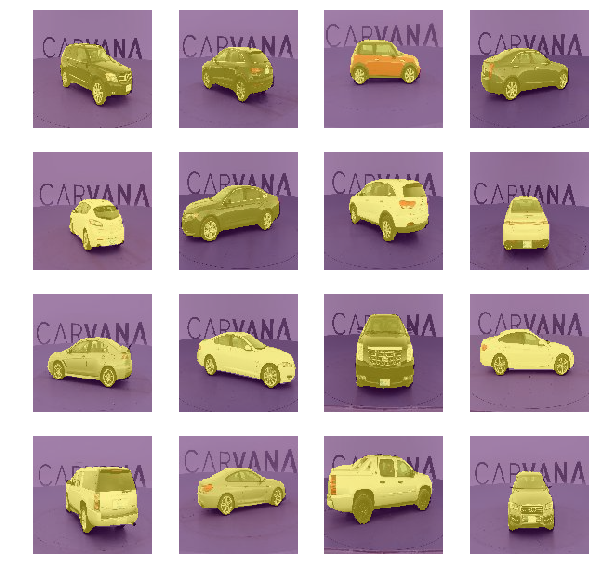

In [ ]:
for i, ax in enumerate(plt.subplots(4,4,figsize=(10,10))[1].flat):
    show_image(default_denorm(x[i].cpu()), py[i], ax=ax)

In [ ]:
learn.save('1')

In [ ]:
size=512
bs = 8
data = get_data(size, bs)
learn.data = data

In [ ]:
learn.load('1')

In [ ]:
learn.freeze()

In [ ]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 08:13
epoch  train loss  valid loss  accuracy  dice    
0      0.030241    0.024570    0.989893  0.976074  (01:39)
1      0.022943    0.022459    0.990906  0.978739  (01:38)
2      0.021962    0.019454    0.991985  0.980987  (01:38)
3      0.020026    0.017755    0.992615  0.982496  (01:38)
4      0.018310    0.016675    0.993064  0.983596  (01:39)



In [ ]:
learn.save('2')

In [ ]:
learn.load('2')

In [ ]:
lr = 2e-2

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(8, slice(lr/100,lr))

Total time: 16:22
epoch  train loss  valid loss  accuracy_thresh  dice    
0      0.016387    0.015025    0.993727         0.985603  (02:00)
1      0.015695    0.014460    0.993621         0.986182  (02:02)
2      0.015260    0.013838    0.994145         0.986763  (02:02)
3      0.014100    0.012950    0.994233         0.987541  (02:03)
4      0.012751    0.011717    0.994986         0.988882  (02:03)
5      0.012189    0.011278    0.995056         0.989228  (02:03)
6      0.012040    0.011185    0.995142         0.989321  (02:03)
7      0.011999    0.011159    0.995115         0.989330  (02:03)



In [ ]:
learn.save('3')

In [ ]:
x,py = learn.pred_batch()

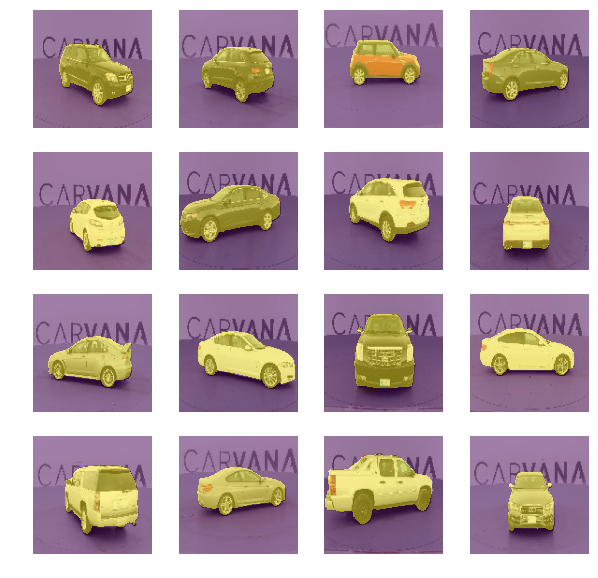

In [ ]:
for i, ax in enumerate(plt.subplots(4,4,figsize=(10,10))[1].flat):
    show_image(default_denorm(x[i].cpu()), py[i]>0, ax=ax)

## Fin